In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
import seaborn as sns
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,learning_curve,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, classification_report
import joblib
import pathlib

加载数据

In [11]:

# 定义加载的特征名字
columns = 'duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target'
columns = columns.split(',')

# 定义标识的类型
attacks_types = {
    'normal': 'normal','back': 'dos','buffer_overflow': 'u2r','ftp_write': 'r2l','guess_passwd': 'r2l','imap': 'r2l','ipsweep': 'probe','land': 'dos','loadmodule': 'u2r','multihop': 'r2l','neptune': 'dos','nmap': 'probe','perl': 'u2r','phf': 'r2l','pod': 'dos','portsweep': 'probe','rootkit': 'u2r','satan': 'probe','smurf': 'dos','spy': 'r2l','teardrop': 'dos','warezclient': 'r2l','warezmaster': 'r2l',
}

# 读取数据，保存到df变量中，特征的名字就是columns定义的
path = "./raw/kddcup.data_10_percent"
df = pd.read_csv(path,names=columns)

In [12]:
# 查看数据中nan值的个数
df.isnull().sum()
# 由于数据中无nan值，因此无需去除df中的nan值

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

数据预处理

In [13]:

# 处理标签
target1=df['target']
le = preprocessing.LabelEncoder()
# 小类标签数字化，共23小类
labels_23_category =le.fit_transform(target1).astype(np.int64)
df["target_digit"]= labels_23_category


# 添加大类标签，共五大类
df['attack_type'] = df.target.apply(lambda r:attacks_types[r[:-1]])
target2=df["attack_type"]
le = preprocessing.LabelEncoder()
# 大类标签数字化
labels_5_category =le.fit_transform(target2).astype(np.int64)
df["attack_type_digit"]=labels_5_category 



In [14]:
# 去除只有唯一值的列
df = df[[col for col in df if df[col].nunique() > 1]]

# 删除具有高相关性的列，可以根据下面绘制的相关性热图来删除掉一些高度相关的列
df.drop('num_root',axis = 1,inplace = True)
df.drop('srv_serror_rate',axis = 1,inplace = True)
df.drop('srv_rerror_rate',axis = 1, inplace=True)
df.drop('dst_host_srv_serror_rate',axis = 1, inplace=True)
df.drop('dst_host_serror_rate',axis = 1, inplace=True)
df.drop('dst_host_rerror_rate',axis = 1, inplace=True)
df.drop('dst_host_srv_rerror_rate',axis = 1, inplace=True)
df.drop('dst_host_same_srv_rate',axis = 1, inplace=True)
df.drop('service',axis = 1,inplace= True)

# 将类别型属性转为数字型属性，比如protocol_type,flag等
# 将protocol_type列离散数值化
pmap = {'icmp':0,'tcp':1,'udp':2}
df['protocol_type'] = df['protocol_type'].map(pmap)
# 将flag列离散数值化
fmap = {'SF':0,'S0':1,'REJ':2,'RSTR':3,'RSTO':4,'SH':5 ,'S1':6 ,'S2':7,'RSTOS0':8,'S3':9 ,'OTH':10}
df['flag'] = df['flag'].map(fmap)


In [15]:

# 划分开数据和标签
x_columns = [c for c in df.columns if c not in ['target','target_digit','attack_type','attack_type_digit']]
X = df[x_columns]
y = df['attack_type'] 

# 对X数据进行归一化
sc = MinMaxScaler()
X = sc.fit_transform(X)

# 将数据集划分为训练集和测试集，划分比例为8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 打印训练集和测试集的大小
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(395216, 30) (98805, 30)
(395216,) (98805,)


In [18]:
# 图片文件路径
df = pd.read_csv(path, header=None, names=columns)
ImagePath = pathlib.Path('.img')
ImagePath.mkdir(parents=True, exist_ok=True)

DT模型调参

In [27]:
# 用GridSearchCV寻找最优参数（字典）
param = {'criterion':['gini'],'max_depth':[30,50,60,100],'min_samples_leaf':[2,3,5,10],'min_impurity_decrease':[0.1,0.2,0.5]}
grid = GridSearchCV(DecisionTreeClassifier(),param_grid=param,cv=6)
grid.fit(X_train,y_train)
print('最优分类器:',grid.best_params_,'最优分数:', grid.best_score_)  # 得到最优的参数和分值

最优分类器: {'criterion': 'gini', 'max_depth': 30, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 2} 最优分数: 0.9767367732235156


训练集的准确率为:  0.9767848467673373
测试集的准确率为:  0.9765902535296797


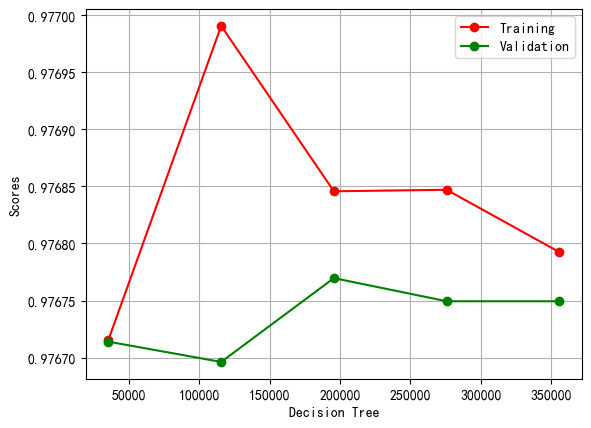

In [19]:
# 调参实验
model1=DecisionTreeClassifier(criterion='gini', max_depth=30, min_impurity_decrease= 0.1, min_samples_leaf=2)
model1.fit(X_train, y_train)
acc_train1 = model1.score(X_train, y_train) 
acc_test1 = model1.score(X_test, y_test) 
train_sizes1,train_scores1,test_scores1 = learning_curve(model1,X_train,y_train,cv=10,n_jobs=4)
plt.grid()
plt.plot(train_sizes1,np.mean(train_scores1,axis=1),'o-',color="r",label="Training")
plt.plot(train_sizes1,np.mean(test_scores1,axis=1),'o-',color="g",label="Validation")
plt.xlabel("Decision Tree")
plt.ylabel("Scores")
plt.legend(loc='best')
save1 = ImagePath / 'model1.png'
plt.savefig(save1)
print("训练集的准确率为: ", acc_train1)
print("测试集的准确率为: ", acc_test1)


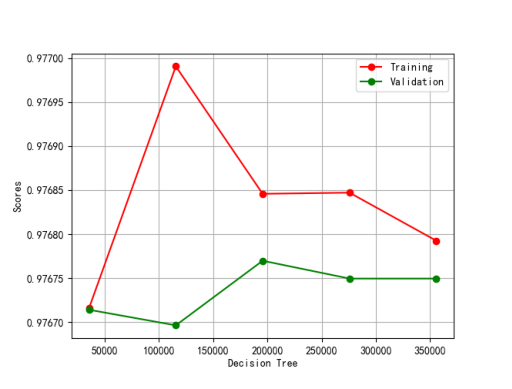

In [27]:
def display_image(image_path):
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# 调用函数并指定图片路径
image_path = '.img/model1.png'
display_image(image_path)

LOGIC模型调参

训练集的准确率为:  0.9935022873567871
测试集的准确率为:  0.9935428369009666


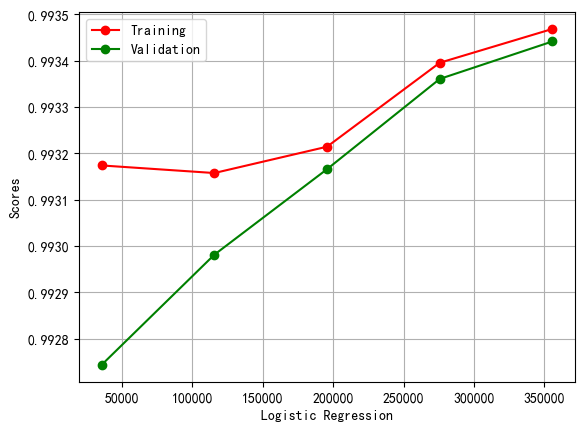

In [28]:
model2 = LogisticRegression(solver='lbfgs',max_iter=1000,C=0.8,penalty='l2')
model2.fit(X_train, y_train)
acc_train2 = model2.score(X_train, y_train) 
acc_test2 = model2.score(X_test, y_test) 
train_sizes2,train_scores2,test_scores2 = learning_curve(model2,X_train,y_train,cv=10,n_jobs=4)
plt.grid()
plt.plot(train_sizes2,np.mean(train_scores2,axis=1),'o-',color="r",label="Training")
plt.plot(train_sizes2,np.mean(test_scores2,axis=1),'o-',color="g",label="Validation")
plt.xlabel("Logistic Regression")
plt.ylabel("Scores")
plt.legend(loc='best')
save2 = ImagePath / 'model2.png'
plt.savefig(save2)
print("训练集的准确率为: ", acc_train2)
print("测试集的准确率为: ", acc_test2)

ANN模型调参

训练集的准确率为:  0.9994180397554755
测试集的准确率为:  0.9991802034310004


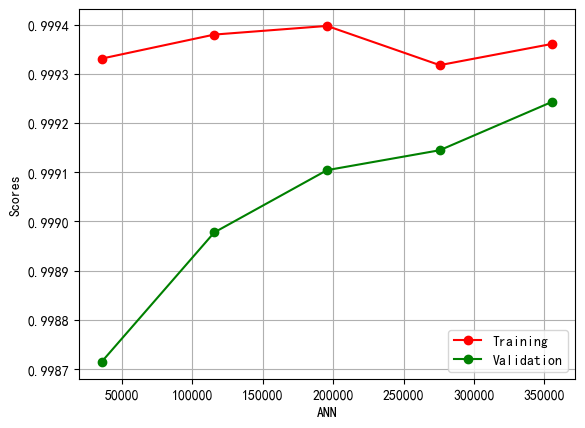

In [29]:
model3 = MLPClassifier(hidden_layer_sizes=(64,16),activation='relu',solver='adam',alpha=0.0001,batch_size=128,learning_rate='constant',max_iter=200)
model3.fit(X_train, y_train)
acc_train3 = model3.score(X_train, y_train) 
acc_test3 = model3.score(X_test, y_test) 
train_sizes3,train_scores3,test_scores3 = learning_curve(model3,X_train,y_train,cv=10,n_jobs=4)
plt.grid()
plt.plot(train_sizes3,np.mean(train_scores3,axis=1),'o-',color="r",label="Training")
plt.plot(train_sizes3,np.mean(test_scores3,axis=1),'o-',color="g",label="Validation")
plt.xlabel("ANN")
plt.ylabel("Scores")
plt.legend(loc='best')
save3 = ImagePath / 'model3.png'
plt.savefig(save3)
print("训练集的准确率为: ", acc_train3)
print("测试集的准确率为: ", acc_test3)

In [12]:
# 用GridSearchCV寻找最优参数（字典）
par = {'hidden_layer_sizes':[(20,),(30,),(40,),(32,8),(64,16),(40,23)]}
gr = GridSearchCV(MLPClassifier(activation='relu',solver='adam',alpha=0.0001,batch_size=128,learning_rate='constant',max_iter=200),param_grid=par,cv=3)
gr.fit(X_train,y_train)
print(gr.cv_results_)
print(gr.best_params_, gr.best_score_)

{'mean_fit_time': array([21.74041947, 23.91863569, 23.01931357, 35.41164867, 52.82029804,
       55.22549613]), 'std_fit_time': array([ 1.19511656,  3.48699868,  2.3252079 , 10.02938057,  9.95757458,
        6.67993523]), 'mean_score_time': array([0.18840941, 0.2039868 , 0.23471292, 0.30039914, 0.39279556,
       0.37249144]), 'std_score_time': array([0.00252344, 0.00572967, 0.00893577, 0.08045439, 0.0237005 ,
       0.01973995]), 'param_hidden_layer_sizes': masked_array(data=[(20,), (30,), (40,), (32, 8), (64, 16), (40, 23)],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'hidden_layer_sizes': (20,)}, {'hidden_layer_sizes': (30,)}, {'hidden_layer_sizes': (40,)}, {'hidden_layer_sizes': (32, 8)}, {'hidden_layer_sizes': (64, 16)}, {'hidden_layer_sizes': (40, 23)}], 'split0_test_score': array([0.99905115, 0.99897525, 0.99913465, 0.99908152, 0.99923333,
       0.99906634]), 'split1_test_score': array([0.99889934, 

模型评估

In [30]:
# 预测
y_pred_model1 = model1.predict(X_test)
y_pred_model2 = model2.predict(X_test)
y_pred_model3 = model3.predict(X_test)

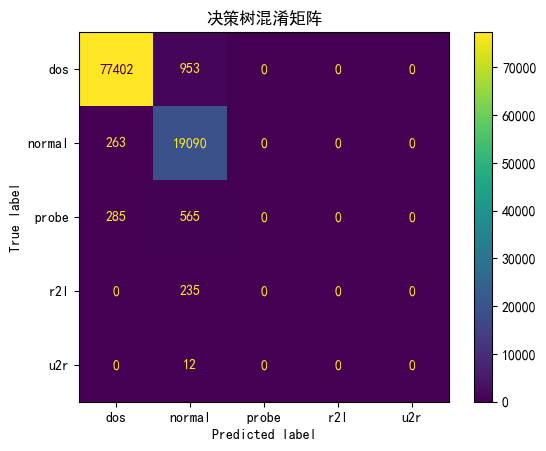

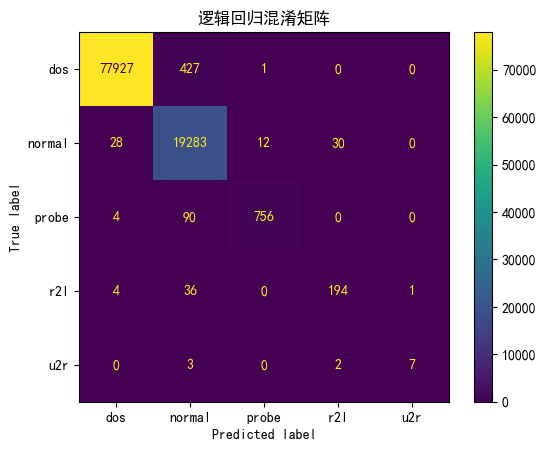

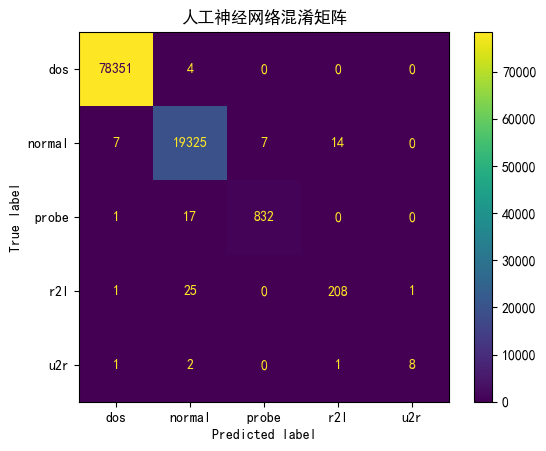

In [31]:
# 绘制混淆矩阵
c1 = confusion_matrix(y_test, y_pred_model1)
ConfusionMatrixDisplay(c1, display_labels=y_test.unique()).plot()
plt.title('决策树混淆矩阵')
save4 = ImagePath / 'matrix1.png'
plt.savefig(save4)

c2 = confusion_matrix(y_test, y_pred_model2)
ConfusionMatrixDisplay(c2, display_labels=y_test.unique()).plot()
plt.title('逻辑回归混淆矩阵')
save5 = ImagePath / 'matrix2.png'
plt.savefig(save5)

c3 = confusion_matrix(y_test, y_pred_model3)
ConfusionMatrixDisplay(c3, display_labels=y_test.unique()).plot()
plt.title('人工神经网络混淆矩阵')
save6 = ImagePath / 'matrix3.png'
plt.savefig(save6)

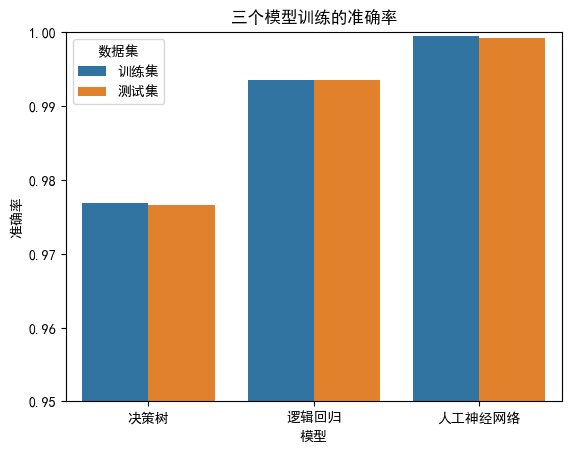

In [36]:
# 准确率比较
df_acc = {
    '模型': [j for j in ['决策树', '逻辑回归', '人工神经网络'] for i in range(2)],
    '准确率': [acc_train1, acc_test1, acc_train2, acc_test2, acc_train3, acc_test3],
    '数据集': [k for i in [1, 2, 3] for k in ['训练集', '测试集']],
}
df_acc = pd.DataFrame(df_acc)
plt.figure()
sns.barplot(x='模型', y='准确率', hue='数据集', data=df_acc)
plt.ylim([0.9500, 1])
plt.title('三个模型训练的准确率')
save7 = ImagePath / 'comparison1.png'
plt.savefig(save7)

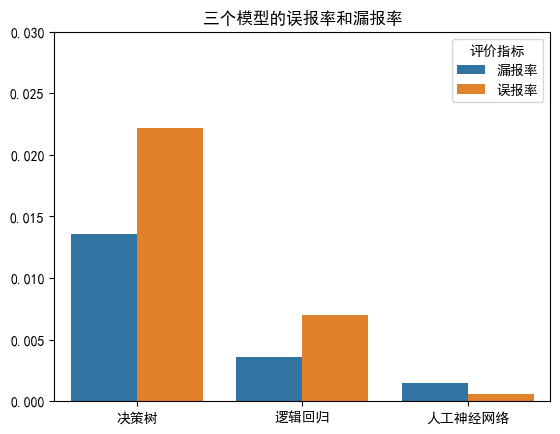

In [35]:
def miss_rate(y_test, y_pred):  # 计算漏报率（假负率）
    FN, TP = 0, 0
    for y, ypre in zip(y_test, y_pred):
        if y == 'normal' and ypre == 'normal':
            TP += 1
        elif y == 'normal' and ypre != 'normal':
            FN += 1
    return FN / (TP + FN)


def false_alarm(y_test, y_pred):  # 计算误报率（假正率）
    FP, TN = 0, 0
    for y, ypre in zip(y_test, y_pred):
        if y != 'normal' and ypre == 'normal':
            FP += 1
        elif y != 'normal' and ypre != 'normal':
            TN += 1
    return FP / (FP + TN)


# 绘制误报率和漏报率比较图（第四个GO）

refe_data = {'模型': [], '值': [], '评价指标': []}
for pred, nm in zip([y_pred_model1, y_pred_model2, y_pred_model3], ['决策树', '逻辑回归', '人工神经网络']):
    lbl = miss_rate(y_test, pred)
    wbl = false_alarm(y_test, pred)
    for i, j in zip(['漏报率', '误报率'], [lbl, wbl]):
        refe_data['模型'].append(nm)
        refe_data['值'].append(j)
        refe_data['评价指标'].append(i)
plt.figure()
sns.barplot(x='模型', y='值', hue='评价指标', data=refe_data)
plt.ylim([0, 0.03])
plt.title('三个模型的误报率和漏报率')
plt.legend(title='评价指标')
save8 = ImagePath / 'comparison2.png'
plt.savefig(save8)